## Toxicity Classification:


### 1. Business Problem:

**Problem Statement:** Given a comment made by the user, predict the toxicity of the comment.


### 2. Machine Learning Problem Formulation:

#### 2.1 Data:
**Source:** https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data

We have one single csv file for training and one cvs file to test.
Columns in train data:
Comment_text: This is the data in string format which we have to use to find the toxicity.
target: Target values which are to be predicted (has values between 0 and 1)
Data also has additional toxicity subtype attributes: (Model does not have to predict these)
severe_toxicity
obscene
threat
insult
identity_attack
sexual_explicit
Comment_text data also has identity attributes carved out from it, some of which are:
male
female
homosexual_gay_or_lesbian
christian
jewish
muslim
black
white
asian
latino
psychiatric_or_mental_illness
Apart from above features the train data also provides meta-data from jigsaw like:
toxicity_annotator_count
identity_anotator_count
article_id
funny
sad
wow
likes
disagree
publication_id
parent_id
article_id
created_date

#### 2.2 Example Datapoints and Labels:

Comment: i'm a white woman in my late 60's and believe me, they are not too crazy about me either!!


Toxicity Labels: All 0.0
Identity Mention Labels: female: 1.0, white: 1.0 (all others 0.0)
Comment: Why would you assume that the nurses in this story were women?


Toxicity Labels: All 0.0
Identity Mention Labels: female: 0.8 (all others 0.0)
Comment: Continue to stand strong LGBT community. Yes, indeed, you'll overcome and you have.

Toxicity Labels: All 0.0
Identity Mention Labels: homosexual_gay_or_lesbian: 0.8, bisexual: 0.6, transgender: 0.3 (all others 0.0)

#### 2.3 Type of Machine Learning Problem:

We have to predict the toxicity level(target attribute). The values range from 0 to 1 inclusive. This is a regression problem. It can also be treated as a classification problem if we take every value below 0.5 to be non-toxic and above it to be toxic, we would then get a binary classification problem.

#### 2.4 Performance Metric:

The competition will use ROC_AUC as the metric after converting the numeric target variable into a categorical variable by using a threshold of 0.5. Any comment above 0.5 will be assumed to be toxic and below it non-toxic. For our training and evaluation we will use the MSE(Mean Squared Error).

#### 2.5 Machine Learning Objectives and Constraints:

Objectives: Predict the toxicity of a comment made by the user. (0 -> not toxic, 1 -> highest toxicity level)

#### Constraints:

The model should be fast to predict the toxicity rating.
Interpretability is not needed.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import gensim
import string
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import Dropout
from keras.layers import Embedding
import warnings
from keras import backend as K
warnings.filterwarnings("ignore")
import tensorflow.keras.backend as K

In [2]:
train_df = pd.read_csv('/content/drive/MyDrive/NLP Projects/train_df.csv', index_col = 'id', engine = 'python')
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
5950810,0.000000,"No, I wasn't for Hillary. You have me confused...",0.000000,0.000000,0.0,0.00000,0.000000,NaN,NaN,NaN,...,377568,approved,1,0,0,0,0,0.0,0,4
1064597,0.000000,10% cash ?\nMy my...first I have heard tell of...,0.000000,0.000000,0.0,0.00000,0.000000,NaN,NaN,NaN,...,316165,approved,0,0,0,1,0,0.0,0,4
930241,0.729730,Merkel is an idoit. Vote for term limits then...,0.027027,0.216216,0.0,0.72973,0.000000,NaN,NaN,NaN,...,165152,approved,0,0,0,0,0,0.0,0,74
408036,0.166667,"I'm sure the city would say something about ""l...",0.000000,0.000000,0.0,0.00000,0.166667,0.0,0.0,0.0,...,142533,approved,0,0,0,1,0,0.0,4,6
6284103,0.000000,"You need to keep up, or at least try. Emergen...",0.000000,0.000000,0.0,0.00000,0.000000,NaN,NaN,NaN,...,396630,approved,0,0,0,1,0,0.0,0,4


In [3]:
test_df = pd.read_csv('/content/drive/MyDrive/NLP Projects/test.csv', index_col = 'id', engine = 'python')
test_df.head()

,comment_text
id,
7097320,[ Integrity means that you pay your debts.]\n\...
7097321,This is malfeasance by the Administrator and t...
7097322,@Rmiller101 - Spoken like a true elitist. But ...
7097323,"Paul: Thank you for your kind words. I do, in..."
7097324,Sorry you missed high school. Eisenhower sent ...


In [4]:
train_df.describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,45157.000000,45157.000000,45157.000000,45157.000000,...,1.138310e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.103324,0.004603,0.013856,0.022697,0.081530,0.009183,0.011885,0.003501,0.002093,0.034851,...,3.718643e+06,281020.738175,0.278340,0.043820,0.108760,2.443205,0.585570,0.006561,1.428935,8.932975
std,0.197270,0.022960,0.064481,0.078911,0.176447,0.049224,0.087754,0.051925,0.027760,0.168898,...,2.452947e+06,104053.293125,1.058845,0.240707,0.453169,4.704380,1.885316,0.044991,17.098078,47.619624
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,8.332800e+04,2867.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.919510e+05,159937.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.222234e+06,332002.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000
75%,0.166667,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.777444e+06,366135.500000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,6.000000
max,1.000000,0.644363,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,6.333875e+06,399539.000000,50.000000,7.000000,17.000000,171.000000,130.000000,1.000000,1848.000000,4936.000000


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 5950810 to 331948
Data columns (total 44 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   target                               200000 non-null  float64
 1   comment_text                         200000 non-null  object 
 2   severe_toxicity                      200000 non-null  float64
 3   obscene                              200000 non-null  float64
 4   identity_attack                      200000 non-null  float64
 5   insult                               200000 non-null  float64
 6   threat                               200000 non-null  float64
 7   asian                                45157 non-null   float64
 8   atheist                              45157 non-null   float64
 9   bisexual                             45157 non-null   float64
 10  black                                45157 non-null   float64
 11  buddhis

In [6]:
train_df.isna().sum()

target                                      0
comment_text                                0
severe_toxicity                             0
obscene                                     0
identity_attack                             0
insult                                      0
threat                                      0
asian                                  154843
atheist                                154843
bisexual                               154843
black                                  154843
buddhist                               154843
christian                              154843
female                                 154843
heterosexual                           154843
hindu                                  154843
homosexual_gay_or_lesbian              154843
intellectual_or_learning_disability    154843
jewish                                 154843
latino                                 154843
male                                   154843
muslim                            

#### No Null values for target and comments columns in dataset

In [7]:
print("Train and test shape: {} {}".format(train_df.shape, test_df.shape))

Train and test shape: (200000, 44) (97320, 1)


# Exploratory Data Analysis

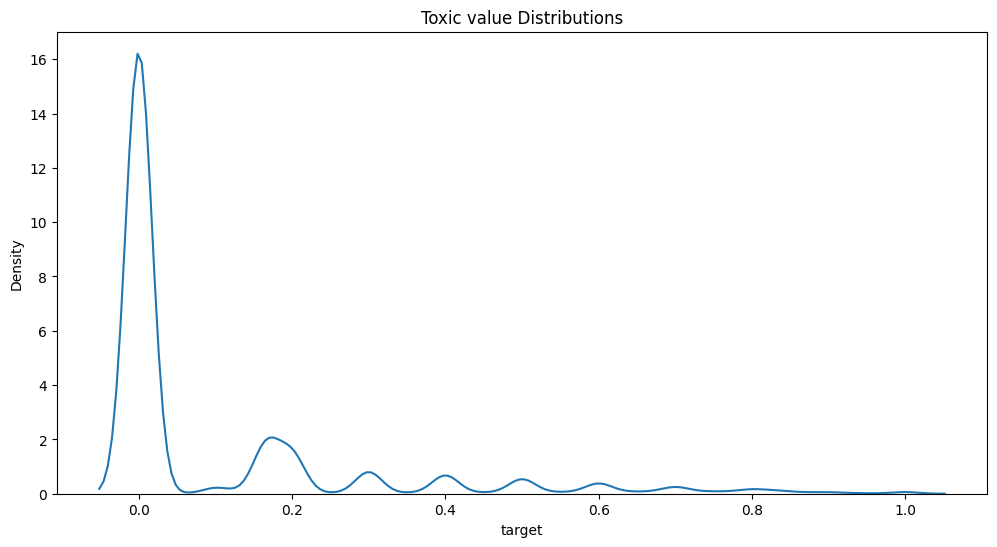

In [8]:
# 1. Toxic fearure

plt.figure(figsize=(12,6))
plt.title("Toxic value Distributions")
sns.distplot(train_df['target'], kde=True, hist=False, bins=240, label='target')
plt.show()

#### Most of the comments present in the dataset are non-toxic i.e. <0.5 and only few of them are actually toxic i.e. > 0.5.

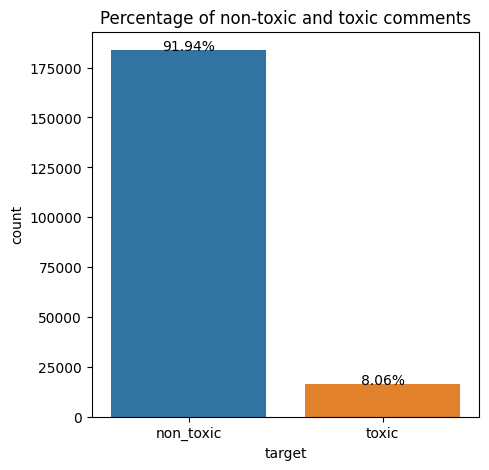

In [9]:
# If toxicity rating < 0.5 then the comment is non-toxic else it is toxic.

temp = train_df['target'].apply(lambda x: "non_toxic" if x < 0.5 else "toxic")


fig,ax = plt.subplots(1,1,figsize=(5,5))
total = float(len(temp))


Plot = sns.countplot(train_df, x = temp)

Plot.set_title('Percentage of non-toxic and toxic comments')

# Height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')

plt.show()

#### The dataset is imbalanced as 92% of the comments are non-toxic and 8% are toxic

### 2. Toxicity Subtype Features

* severe_toxicity
* obscene
* threat
* insult
* identity_attack

In [10]:
def plot_distribution(features, title, data):

  plt.figure(figsize=(12,6))
  plt.title(title)
  for feature in features:
    sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
  plt.xlabel('')
  plt.legend()
  plt.show()

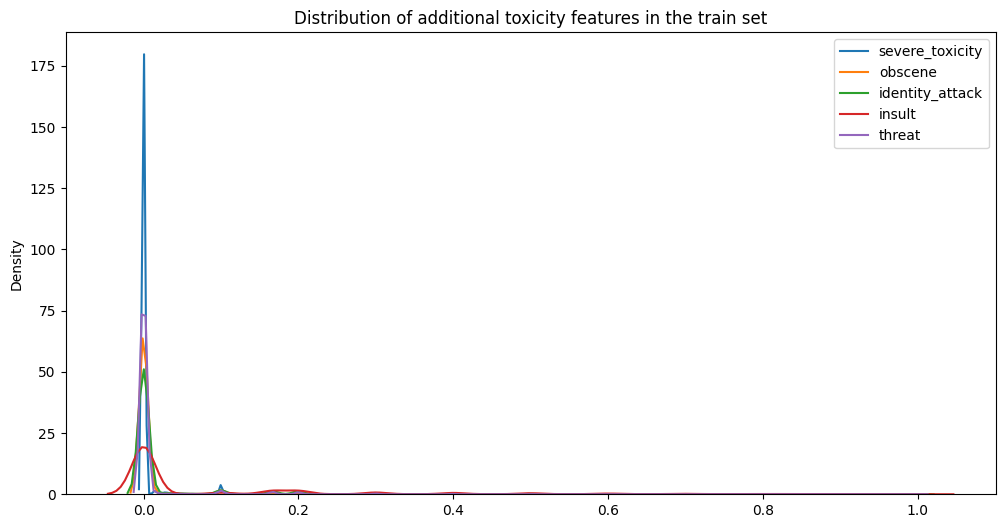

In [11]:
features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
plot_distribution(features, "Distribution of additional toxicity features in the train set", train_df)

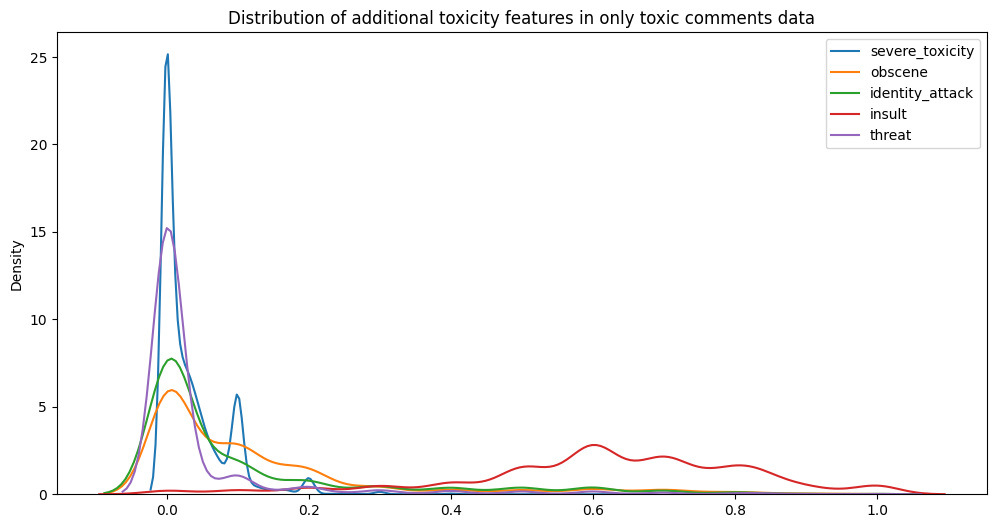

In [12]:
# Looking at the distribution of additional toxicity features on the comments that are actually considered toxic:
temp = train_df[train_df['target'] > 0.5]
plot_distribution(features, "Distribution of additional toxicity features in only toxic comments data", temp)

There are more insulting comments than obscene comments

In [13]:
# Getting the count of additonal toxicity features in toxic comments data(temp):
def get_comment_nature(row):
    # Extract type of toxic comment
    row = [row['severe_toxicity'], row['obscene'], row['identity_attack'], row['insult'], row['threat']]

    maxarg = np.argmax(np.array(row)) # Get the max value index.

    if maxarg == 0: return 'severe_toxicity'
    elif maxarg == 1: return 'obscene'
    elif maxarg == 2: return 'identity_attack'
    elif maxarg == 3: return 'insult'
    else: return 'threat'

# 3. Identity Attributes:

Sensitive topics:

* male
* female
* homosexual_gay_or_lesbian
* bisexual
* heterosexual
* christian
* jewish
* muslim
* black
* white
* asian
* latino

In [14]:
temp = train_df.dropna(axis = 0, how = 'any')

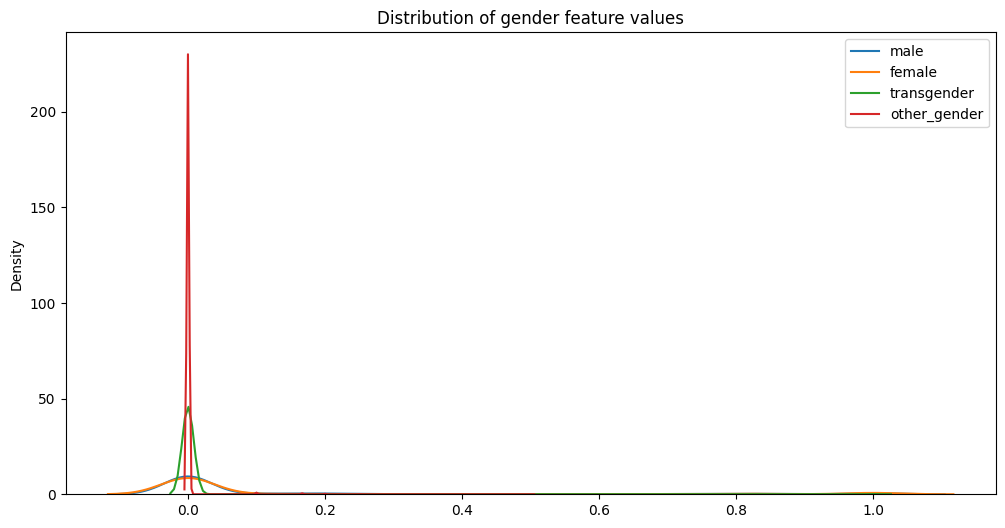

In [15]:
features = ['male', 'female', 'transgender', 'other_gender']
plot_distribution(features, "Distribution of gender feature values", temp)

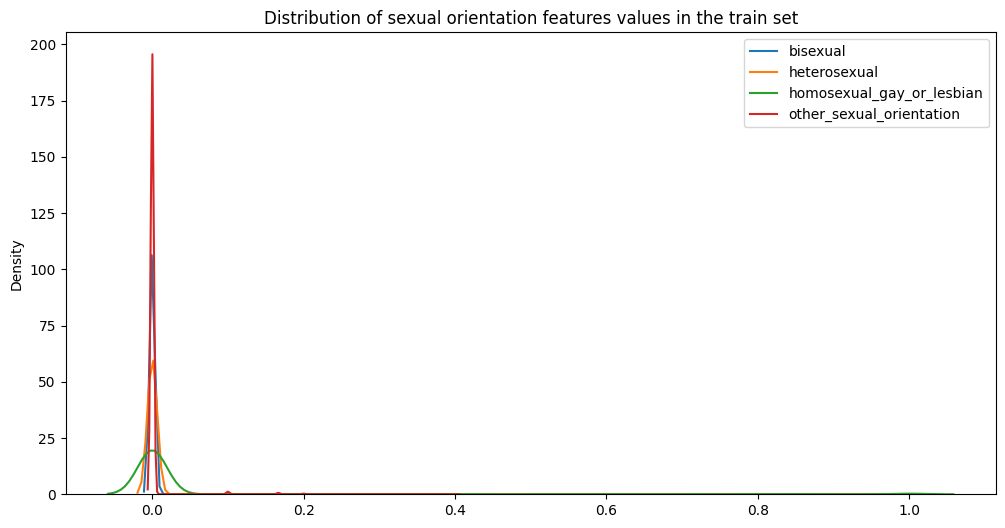

In [16]:
features = ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
plot_distribution(features, "Distribution of sexual orientation features values in the train set", temp)

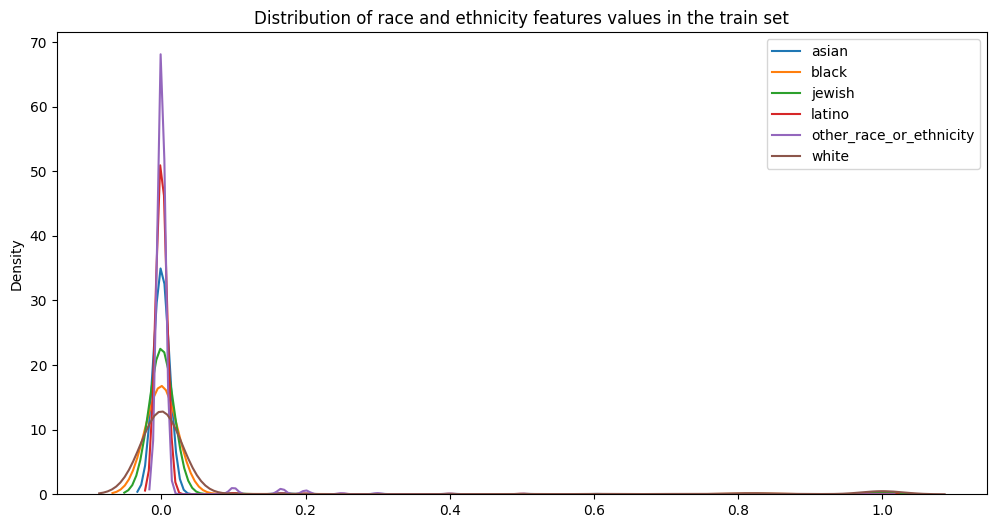

In [17]:
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
plot_distribution(features, "Distribution of race and ethnicity features values in the train set", temp)

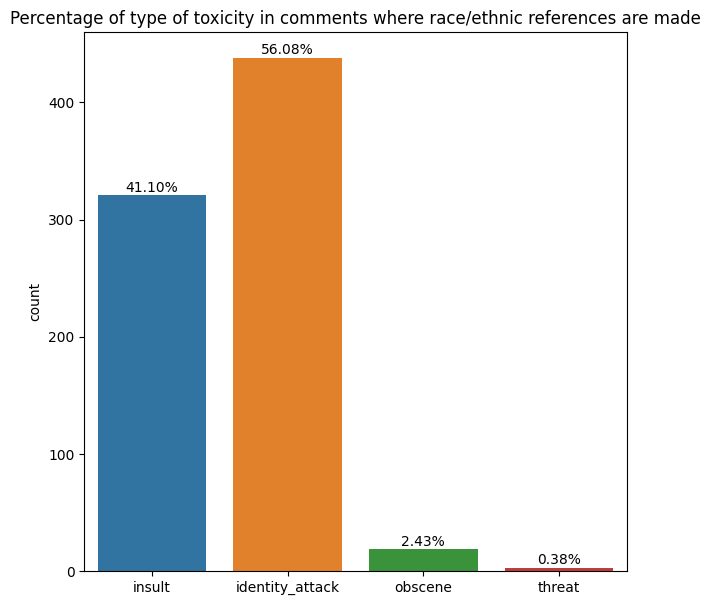

In [18]:
# Get data where race/ethnic references are made.
cond = (train_df['asian'] > 0.5) | (train_df['black'] > 0.5) | (train_df['jewish'] > 0.5) | (train_df['latino'] > 0.5) | (train_df['white'] > 0.5)
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x,x=x)
cntplot.set_title('Percentage of type of toxicity in comments where race/ethnic references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')

plt.show()

#### Toxic comments involving words like black, asian, jewish, latino are mainly used for identity attacks or insults.

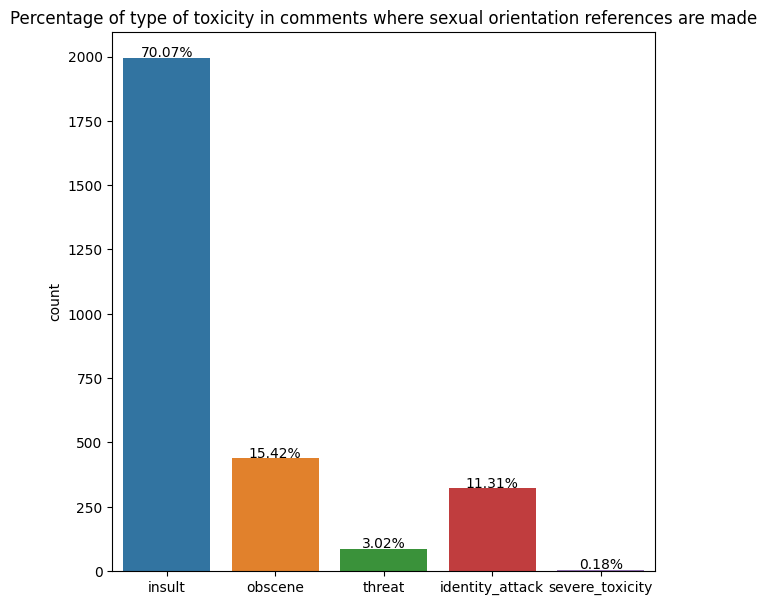

In [19]:
# Get data where race/ethnic references are made.
cond = (train_df['bisexual'] > 0.5) | (train_df['heterosexual'] > 0.5) | (train_df['homosexual_gay_or_lesbian'] > 0.5) | (train_df['other_sexual_orientation']) | (train_df['sexual_explicit'])
temp = train_df[cond]
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1)

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x,x=x)
cntplot.set_title('Percentage of type of toxicity in comments where sexual orientation references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')

plt.show()

 #### Toxic comments where sexual orientation references are made are mostly used for identity attacks.

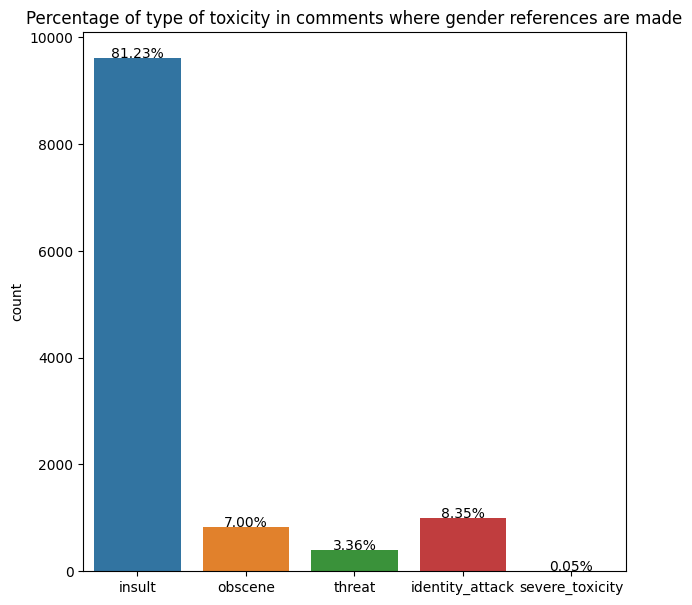

In [20]:
 # Get data where race/ethnic references are made.

cond = (train_df['male']>0.5) | (train_df['female']>0.5) | (train_df['other_gender']>0.5) | (train_df['transgender']>0.5)
temp = train_df[cond]
temp = train_df[train_df['target']>0.5]  # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1)
fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x,x=x)
cntplot.set_title('Percentage of type of toxicity in comments where gender references are made')

# Get the height and calculate percentage then display it the plot itself.

for p in ax.patches:
  # Get height
  height = p.get_height()
  # Plot at appropriate position.
  ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')

plt.show()

#### Toxic comments which involves male, female etc. are mostly insults.

## 4. Features generated by users feedback:
* funny
* sad
* wow
* likes
* disagree

In [21]:
def plot_count(feature, title, data, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(data))
    g = sns.countplot(data[feature], order = data[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center")
    plt.show()

## 5. Comments_text Feature:

In [22]:
from wordcloud import WordCloud, STOPWORDS

In [23]:
stpwrds = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stpwrds,
        max_words=50,
        max_font_size=40,
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

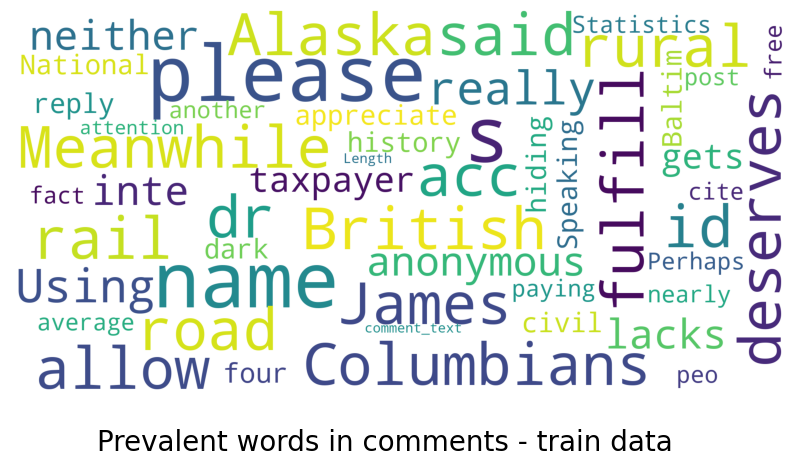

In [24]:
show_wordcloud(train_df['comment_text'].sample(20000), title = 'Prevalent words in comments - train data')

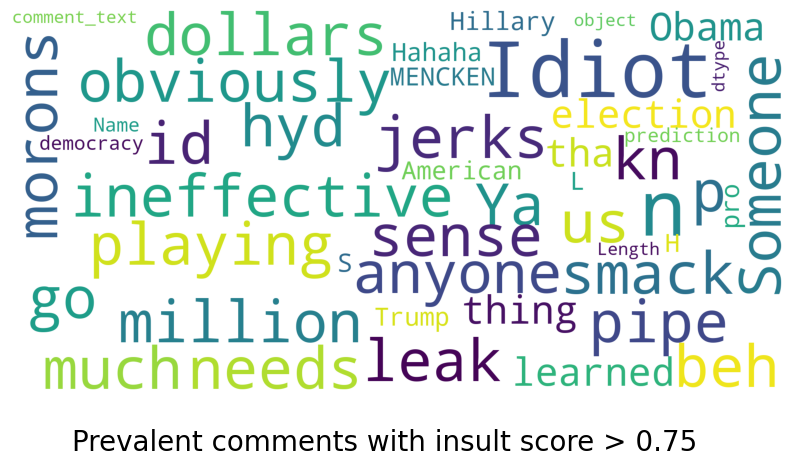

In [25]:
show_wordcloud(train_df.loc[train_df['insult'] > 0.75]['comment_text'], title = 'Prevalent comments with insult score > 0.75')

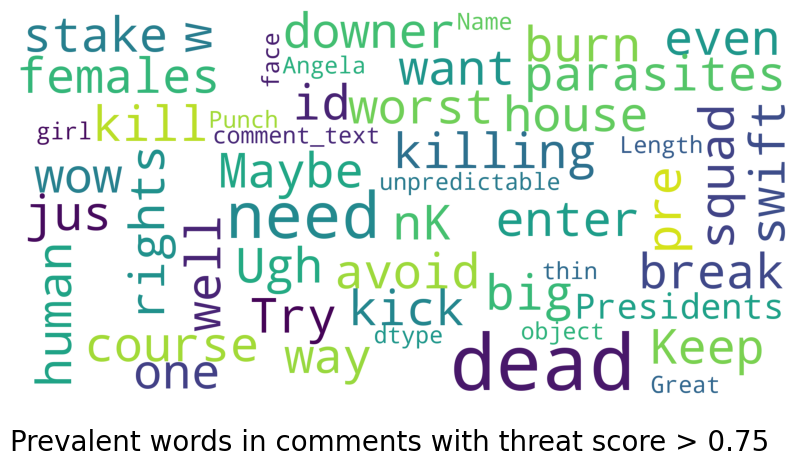

In [26]:
show_wordcloud(train_df.loc[train_df['threat'] > 0.75]['comment_text'],
               title = 'Prevalent words in comments with threat score > 0.75')

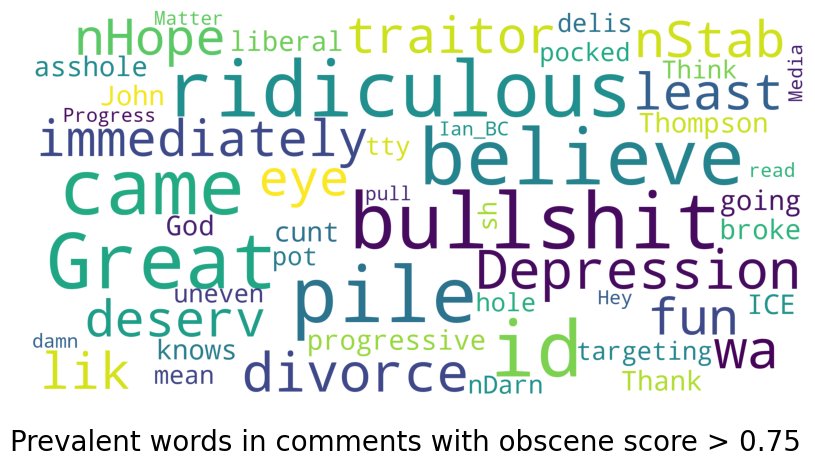

In [27]:
show_wordcloud(train_df.loc[train_df['obscene'] > 0.75]['comment_text'],
               title = 'Prevalent words in comments with obscene score > 0.75')

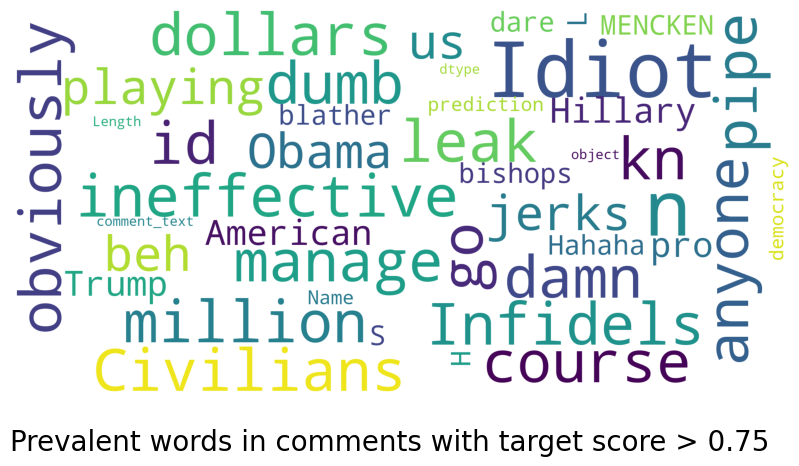

In [28]:
show_wordcloud(train_df.loc[train_df['target'] > 0.75]['comment_text'],
               title = 'Prevalent words in comments with target score > 0.75')

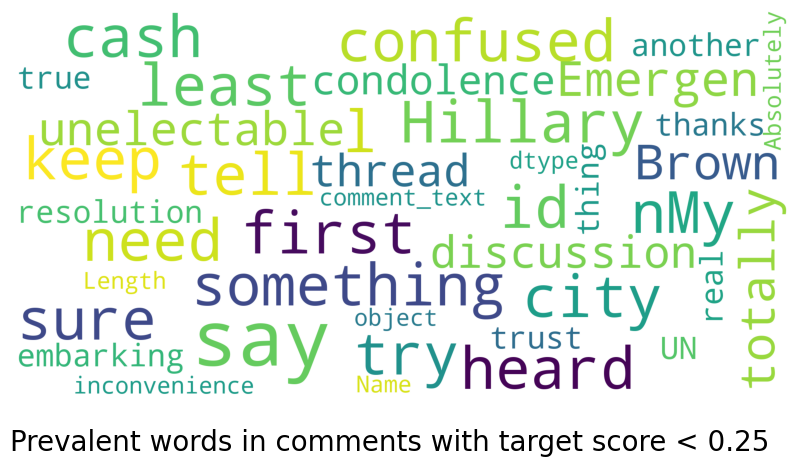

In [29]:
show_wordcloud(train_df.loc[train_df['target'] < 0.25]['comment_text'],
               title = 'Prevalent words in comments with target score < 0.25')

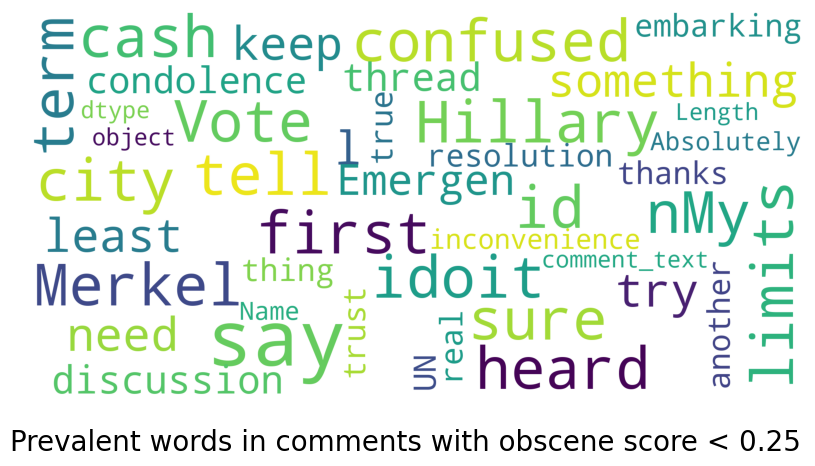

In [30]:
show_wordcloud(train_df.loc[train_df['obscene']< 0.25]['comment_text'],
               title = 'Prevalent words in comments with obscene score < 0.25')

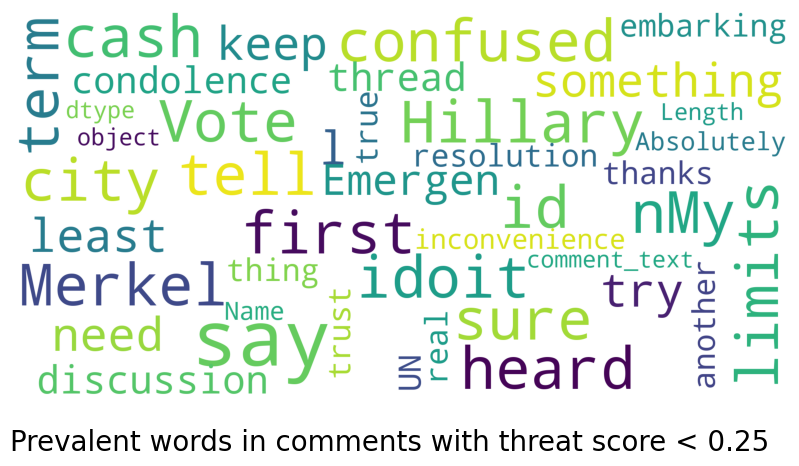

In [31]:
show_wordcloud(train_df.loc[train_df['threat'] < 0.25]['comment_text'],
               title = 'Prevalent words in comments with threat score < 0.25')

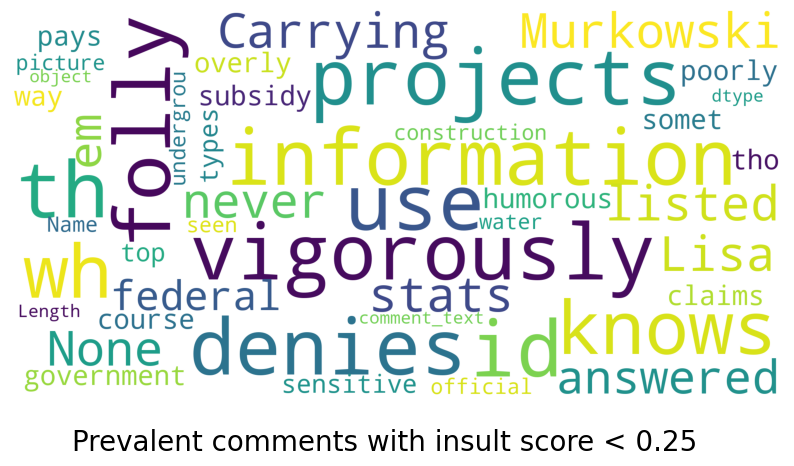

In [32]:
show_wordcloud(train_df.loc[train_df['insult'] < 0.25]['comment_text'].sample(20000),
               title = 'Prevalent comments with insult score < 0.25')

# Preprocessing Text and Train-Test Split:

In [33]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [34]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words("english"))

def preprocess(text_string):
  text_string = text_string.lower()
  # Convert everything to lower case.
  text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations

  x = text_string.split()
  new_text = []

  for word in x:
    if word not in stop_words:
      new_text.append(stemmer.stem(word))

  text_string = ' '.join(new_text)
  return text_string

In [35]:
%%time
train_df['preprocessed_text'] = train_df['comment_text'].apply(preprocess)

CPU times: user 1min 42s, sys: 263 ms, total: 1min 42s
Wall time: 1min 53s


In [36]:
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,preprocessed_text
id,,,,,,,,,,,,,,,,,,,,,
5950810,0.000000,"No, I wasn't for Hillary. You have me confused...",0.000000,0.000000,0.0,0.00000,0.000000,NaN,NaN,NaN,...,approved,1,0,0,0,0,0.0,0,4,hillari confus someon els
1064597,0.000000,10% cash ?\nMy my...first I have heard tell of...,0.000000,0.000000,0.0,0.00000,0.000000,NaN,NaN,NaN,...,approved,0,0,0,1,0,0.0,0,4,10 cash first heard tell sold much enb recent ...
930241,0.729730,Merkel is an idoit. Vote for term limits then...,0.027027,0.216216,0.0,0.72973,0.000000,NaN,NaN,NaN,...,approved,0,0,0,0,0,0.0,0,74,merkel idoit vote term limit listen
408036,0.166667,"I'm sure the city would say something about ""l...",0.000000,0.000000,0.0,0.00000,0.166667,0.0,0.0,0.0,...,approved,0,0,0,1,0,0.0,4,6,sure citi would say someth liabil blah blah bl...
6284103,0.000000,"You need to keep up, or at least try. Emergen...",0.000000,0.000000,0.0,0.00000,0.000000,NaN,NaN,NaN,...,approved,0,0,0,1,0,0.0,0,4,need keep least tri emerg depart requir law ac...


In [37]:
%%time
test_df['preprocessed_text'] = test_df['comment_text'].apply(preprocess)

CPU times: user 46.8 s, sys: 91.5 ms, total: 46.9 s
Wall time: 49.2 s


In [38]:
test_df.head()

,comment_text,preprocessed_text
id,,
7097320,[ Integrity means that you pay your debts.]\n\...,integr mean pay debt appli presid trump
7097321,This is malfeasance by the Administrator and t...,malfeas administr board wast money
7097322,@Rmiller101 - Spoken like a true elitist. But ...,rmiller101 spoken like true elitist look bud a...
7097323,"Paul: Thank you for your kind words. I do, in...",paul thank kind word inde strong belief hide b...
7097324,Sorry you missed high school. Eisenhower sent ...,sorri miss high school eisenhow sent troop vie...


In [39]:
feature = train_df[['preprocessed_text']]
output = train_df[['target']]
X_train, X_cv, y_train, y_cv = train_test_split(feature, output)

print(X_train.shape)
print(X_cv.shape)
print(y_train.shape)
print(y_cv.shape)

(150000, 1)
(50000, 1)
(150000, 1)
(50000, 1)


In [40]:
X_train.head()

,preprocessed_text
id,
892667,problem old guy run drug show anchorag sure ol...
5136016,oh boo hoo anoth sob stori liber kool aid fact...
6102489,beauti articl well written made cri lost mum 1...
701054,oh yawn
5546798,actual understand scientif method realiz 90 co...


In [41]:
X_cv.head()

,preprocessed_text
id,
5180056,essenti articl share us googl inc owner tube o...
726378,hmm hope funni least insight articl disappoint...
503343,hand soro run presid claim genius
629082,surround hous could arrest howev cri babi publ...
6061818,artifici rang limit way hobbl hors


In [42]:
X_test = test_df[['preprocessed_text']]
X_test.head()

,preprocessed_text
id,
7097320,integr mean pay debt appli presid trump
7097321,malfeas administr board wast money
7097322,rmiller101 spoken like true elitist look bud a...
7097323,paul thank kind word inde strong belief hide b...
7097324,sorri miss high school eisenhow sent troop vie...


In [43]:
# Saving the files to csv so that we dont need to preprocess again.

X_train.to_pickle('X_train.pkl')
X_cv.to_pickle('X_cv.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_cv.to_pickle('y_cv.pkl')

# Training Models:

In [44]:
# To load the csv files:
# Uncomment the block.
X_train = pd.read_pickle('X_train.pkl')
X_cv = pd.read_pickle('X_cv.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_cv = pd.read_pickle('y_cv.pkl')

# 1. Bag of Words (BoW):

In [45]:
cnt_vec = CountVectorizer(ngram_range=(1,2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['preprocessed_text'])
bow_cv = cnt_vec.transform(X_cv['preprocessed_text'])
bow_test = cnt_vec.transform(X_test['preprocessed_text'])

print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

(150000, 30000)
(50000, 30000)
(97320, 30000)


### 1.1 SGDRegressor

#### Hyperaparameter tuning

In [46]:
# Performing hyperparameter tuning:

alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")

        model = SGDRegressor(alpha=a, penalty=p)
        model.fit(bow_train, y_train) # Train

        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)

        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)

        if err < best_error: # Get best model trained
            best_error = err
            best_model = model

        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.0232593970828921
Mean Squared Error on cv set:  0.024213449232767477
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  0.022601001155260134
Mean Squared Error on cv set:  0.024196373057568627
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.024931056230936024
Mean Squared Error on cv set:  0.025254348808187933
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.022725928051751557
Mean Squared Error on cv set:  0.024237908644130647
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.031544255111335386
Mean Squared Error on cv set:  0.0317242577313388
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.023146248575342632
Mean Squared Error on cv set:  0.024552748291793262
***************************************

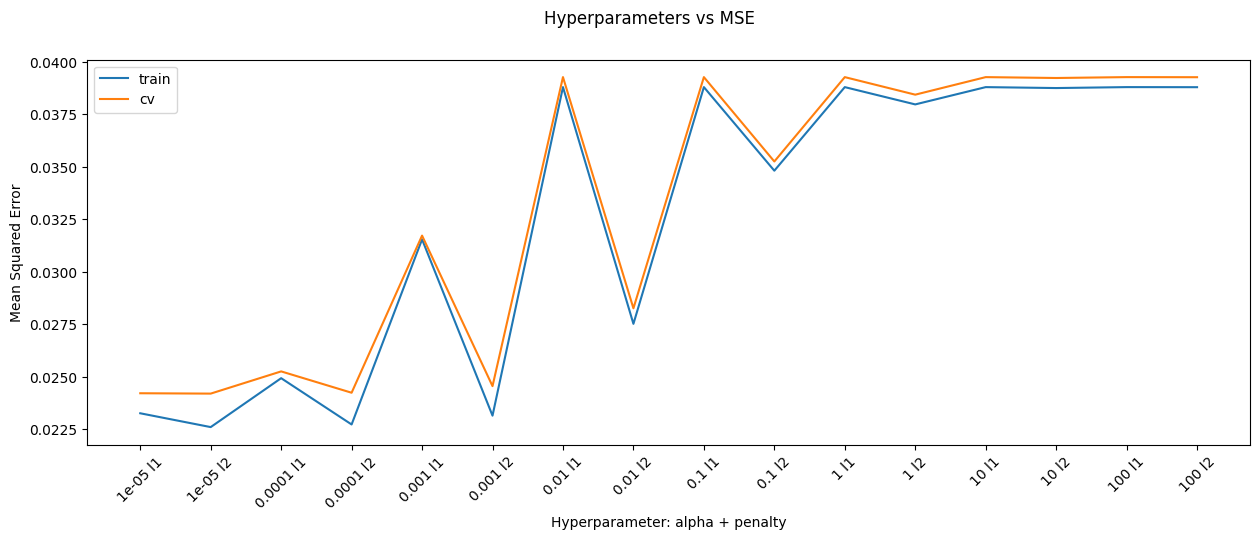

In [47]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

In [48]:
# Getting the best model parameters:
best_model.get_params()

{'alpha': 1e-05,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_error',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

#### 1.1.2 Feature importance

In [50]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names_out()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
idiot,0.405986
stupid,0.353831
crap,0.250014
pathet,0.240822
dumb,0.238464
fool,0.216497
hypocrit,0.214575
loser,0.209049
moron,0.206377
clown,0.202596


In [51]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
monorail,-0.032539
monorail monorail,-0.031654
black white,-0.028385
men women,-0.020677
perpetr,-0.019660
trump want,-0.019644
fool peopl,-0.019277
black hole,-0.019140
white american,-0.018588
black market,-0.018164


### 1.2 Decision Tree

#### 1.2.1 Hyperparameter Tuning

In [52]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")

        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train

        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)

        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)

        if err < best_error: # Get best model trained
            best_error = err
            best_model = model

        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.033217266352831766
Mean Squared Error on cv set:  0.03338145405235044
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03322556225929272
Mean Squared Error on cv set:  0.03337468324613867
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03505177208575816
Mean Squared Error on cv set:  0.03519710245365352
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03210738891608373
Mean Squared Error on cv set:  0.03254473751772722
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.032168414630604485
Mean Squared Error on cv set:  0.03250262653813425
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on trai

<function matplotlib.pyplot.show(close=None, block=None)>

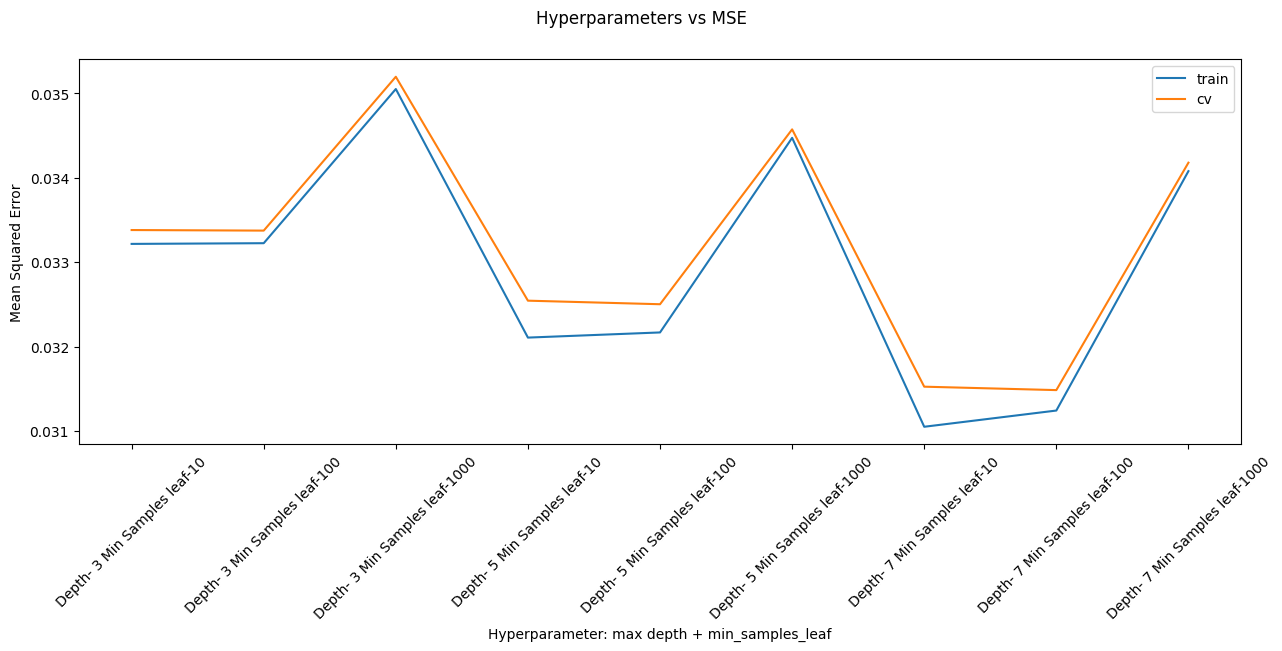

In [53]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show

In [54]:
# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 100,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

#### 1.2.2 Feature Importances

In [55]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.383153
idiot,0.268718
fool,0.078195
racist,0.067174
crap,0.064828
pathet,0.062693
dumb,0.056801
even,0.003624
peopl,0.003526
would,0.002728


### 2. Term Frequency - Inverse Document Frequency (TFIDF) :

In [56]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train['preprocessed_text'])
tfidf_cv = tfidf_vec.transform(X_cv['preprocessed_text'])
tfidf_test = tfidf_vec.transform(X_test['preprocessed_text'])

print(tfidf_train.shape)
print(tfidf_cv.shape)
print(tfidf_test.shape)

(150000, 30000)
(50000, 30000)
(97320, 30000)


### 2.1 SGDRegressor:

#### 2.1.1 Hyperparameter Tuning:

In [57]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")

        model = SGDRegressor(alpha=a, penalty=p)
        model.fit(tfidf_train, y_train) # Train

        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)

        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)

        if err < best_error: # Get best model trained
            best_error = err
            best_model = model

        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.033310699816118776
Mean Squared Error on cv set:  0.033583208790579126
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  0.032804806292099455
Mean Squared Error on cv set:  0.03316287575452722
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.03511944074941636
Mean Squared Error on cv set:  0.03543138993374726
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.03289391770088664
Mean Squared Error on cv set:  0.033253051091837106
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.03867516677183042
Mean Squared Error on cv set:  0.03913125076855572
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.03372065041369782
Mean Squared Error on cv set:  0.03409769831894929
*******************************************

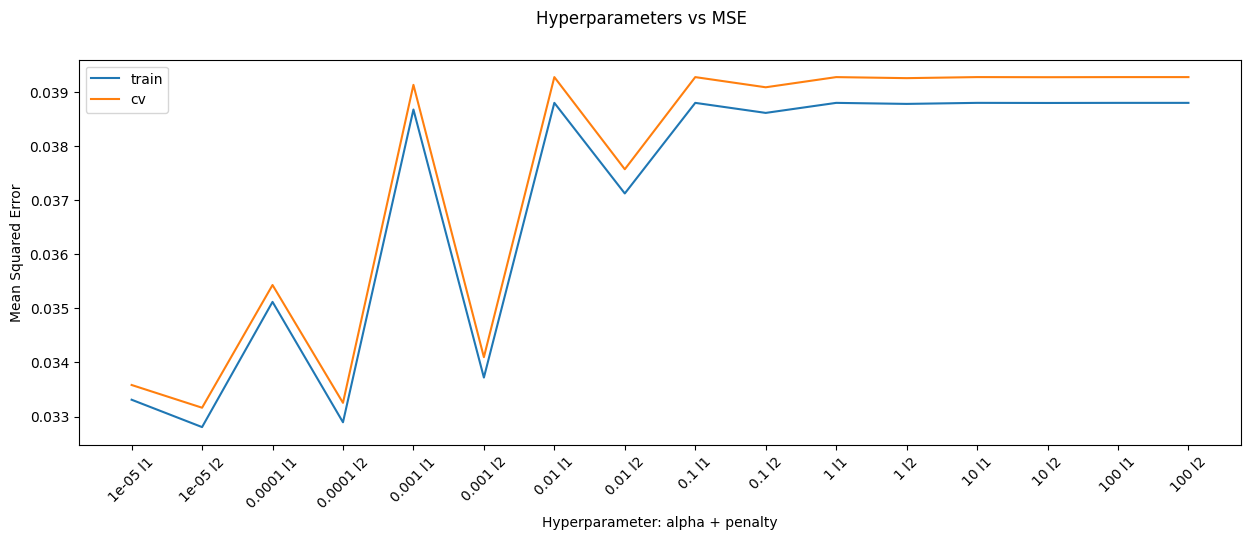

In [58]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

2.1.2 Feature importances

In [60]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = tfidf_vec.get_feature_names_out()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.440138
idiot,0.354797
trump,0.239744
white,0.206439
racist,0.198365
ignor,0.194135
fool,0.175185
kill,0.161595
black,0.155764
loser,0.144845


In [61]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
thank,-0.038460
cost,-0.030594
incom,-0.028566
tax,-0.028248
year,-0.027922
work,-0.026995
agre,-0.024123
provid,-0.023676
www,-0.023469
com,-0.022192


2.2 Decision Tree

2.2.1 Hypeparameter Tuning

In [62]:
  # Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")

        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(tfidf_train, y_train) # Train

        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)

        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)

        if err < best_error: # Get best model trained
            best_error = err
            best_model = model

        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.032992983336016184
Mean Squared Error on cv set:  0.03316375437603761
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.032992983336016184
Mean Squared Error on cv set:  0.03316375437603761
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.034991528005669306
Mean Squared Error on cv set:  0.03518996894584929
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03183189968210031
Mean Squared Error on cv set:  0.032108400735124394
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03187078145385801
Mean Squared Error on cv set:  0.03209277494071975
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on tr

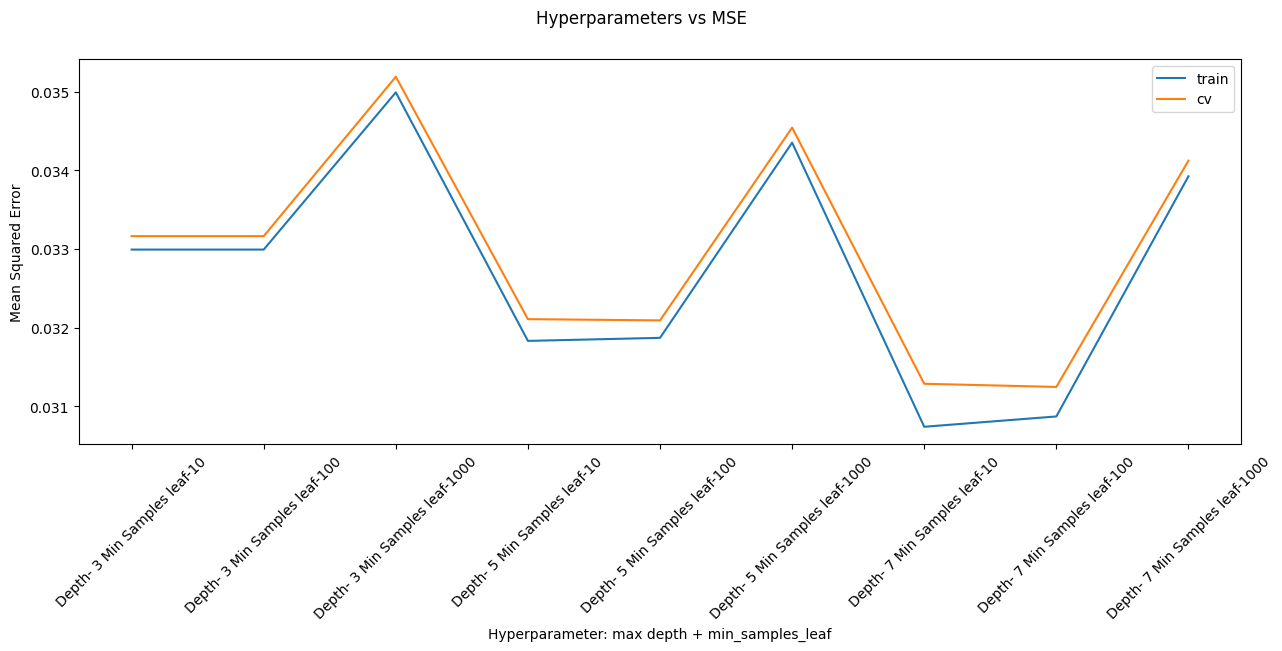

In [63]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

2.2.2 Feature importances

In [64]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.392291
idiot,0.268490
fool,0.082564
racist,0.067944
pathet,0.065323
crap,0.064736
dumb,0.054781
white,0.003035
trump,0.000748
one,0.000087


### 3. Features for LSTM:

In [76]:
class LSTMFeaturization:

    def __init__(self):
        self.word_mapping = None
        self.total_words = None


    # Accepts a list of sentences and builds a vocabulary.
    def build_vocabulary(self, sentences):

        vocab = set()
        for x in sentences:
            for word in x.split():
                vocab.add(word)

        # Create a dictionary from vocabulary.
        vocab_dict = dict.fromkeys(vocab, 0)

        # Calculate count of each word..
        for x in sentences:
            for word in x.split():
                vocab_dict[word]+=1

        return vocab_dict



    # Accepts a dictionary (vocabulary) and gets the word number in dictionary format
    def get_mapping(self, vocab_dict):

        # Get the number of each word into the corpus.
        k = []
        v = []
        for keys,val in vocab_dict.items():
            k.append(keys)
            v.append(val)

        kv = np.vstack((k,v)).T
        df = pd.DataFrame(columns=["Word","Count"], data=kv)
        df['Count'] = df['Count'].astype('int')

        # Sort the dataframe to get the largest count
        df.sort_values(by=['Count'], ascending=False, inplace=True)

        # Give numbering to the most frequent word as 1 then next as 2 and so on.
        df.reset_index(inplace=True)
        df['mapping'] = df.index + 1

        df.drop(columns=['index'], inplace=True)
        df.drop(columns=['Count'], inplace=True)

        # Convert to dictionary for easier processing.
        dictionary = dict(zip(df['Word'], df['mapping']))

        return dictionary


    # Accepts a list of sentences and generates vocabulary and word mappings.
    def fit(self, sentences):
        v = self.build_vocabulary(sentences)
        self.word_mapping = self.get_mapping(v)
        self.total_words = len(self.word_mapping)

    # Converts the sentences to number mappings.
    def transform(self, sentences, pad_length = 350):

        whole = list() # Stores mapping for all sentences
        for x in sentences: # for each sentence in list of sentences.

            part = list()
            for word in x.split(): # for each word
                if word in self.word_mapping:
                    part.append(self.word_mapping[word]) # Append mapped number.
            whole.append(part) # Append sentence.

        # Append additional values to make lengths equal.
        whole = keras.preprocessing.sequence.pad_sequences(np.array(whole), maxlen=pad_length)

        return whole

In [77]:
lstmfeat = LSTMFeaturization()
lstmfeat.fit(X_train['preprocessed_text'])

In [90]:
from keras.utils import pad_sequences

In [93]:
import tensorflow as tf
print(tf.__version__)


2.12.0


In [84]:
# create the model
embedding_vecor_length = 100
total_words = lstmfeat.total_words
model = Sequential()
model.add(Embedding(total_words ,embedding_vecor_length, input_length=350))
model.add(CuDNNLSTM(128, return_sequences=True))
model.add(CuDNNLSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 100)          6466900   
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 350, 128)          117760    
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 128)               132096    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 6,716,885
Trainable params: 6,716,885
Non-trainable params: 0
_________________________________________________________________
None


In [105]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

## Conclusions:

#### 1. BagOfWords:
* SGDRegressor:
    * Hyperparameters Tuned Values: learning_rate(alpha): 1e-05 and penalty: l2
    * Train MSE Loss: 0.02325
    * CV MSE Loss: 0.02421

* Decision Tree:
    * Hyperparameters Tuned Values: max_depth: 7 and min_samples_leaf: 100
    * Train MSE Loss: 0.03321
    * CV MSE Loss: 0.03338
    
#### 2. TFIDF:
* SGDRegressor:
    * Hyperparameters Tuned Values: learning_rate(alpha): 1e-05 and penalty: l2
    * Train MSE Loss: 0.03331
    * CV MSE Loss: 0.03358

* Decision Tree:
    * Hyperparameters Tuned Values: max_depth: 7 and min_samples_leaf: 100
    * Train MSE Loss: 0.03329
    * CV MSE Loss: 0.03316
    
#### 3. LSTM:
* Train MSE Loss: 0.0157
* CV MSE Loss: 0.0162